# Lecture 2: Introduction to Language Modeling

In this lecture, we will introduce the concept of language modeling and implement a bigram language model.

Let's make a bigram language model that generates names character by character.

## Bigram Language Model

Bigram language model is a statistical language model that predicts the next token based on the current token.

For example, given the sentence "A cat sat on the mat"
- A -> cat
- cat -> sat
- sat -> on
- on -> the
- the -> mat

For practical reasons, let's use a character-level language model.

### Importing Libraries

In [ ]:
import os
import sys

project_path = r"C:\\Users\\delta\\Documents\\GitHub\\LLM101n"
sys.path.insert(0, project_path)

In [2]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch
from torch.nn import functional as F
from utils import load_text, set_seed
%matplotlib inline

### Configuration

In [ ]:
@dataclass
class BigramConfig:
    root_dir: str = os.getcwd() + "/../../"
    dataset_path: str = "data/names.txt"
    
    # Tokenizer
    vocab_size: int = 0  # Set later

    seed: int = 101

config = BigramConfig()

### Reproducibility

In [4]:
set_seed(config.seed)
generator = torch.Generator().manual_seed(config.seed)

Random seed set to 101


### Dataset

In [5]:
# Load text and split by lines
names = load_text(config.root_dir + config.dataset_path).splitlines()

Loaded text data from c:\Users\delta\Documents\GitHub\LLM101n\notebooks\Lectures/../../data/names.txt (length: 228145 characters).


#### Statistics

In [7]:
################################################################################
# TODO:                                                                        #
# Print some info about the dataset                                            #
# number of names, the first 5 names, min/max name length, etc.                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
print(names[:5])
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

['emma', 'olivia', 'ava', 'isabella', 'sophia']


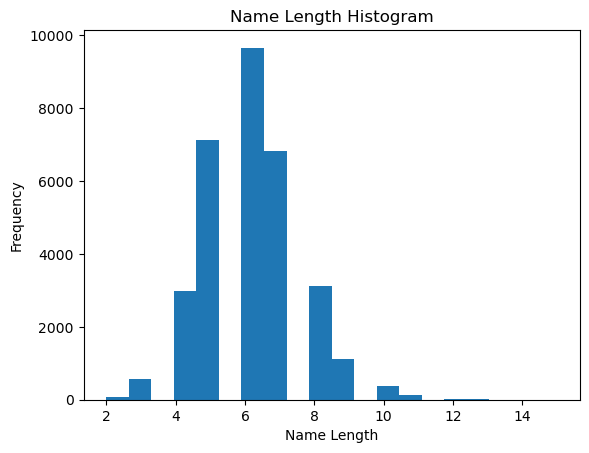

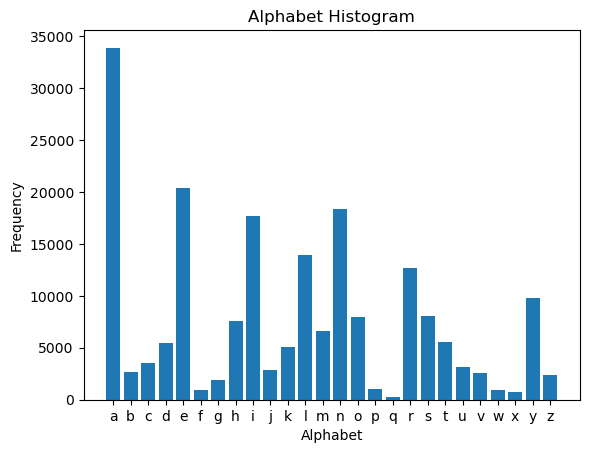

In [8]:
# Plot name length
plt.hist([len(name) for name in names], bins=20)
plt.xlabel("Name Length")
plt.ylabel("Frequency")
plt.title("Name Length Histogram")
plt.show()

# Plot alphabet frequency
alphabet = [chr(i) for i in range(97, 123)]  # all alphabet characters
alphabet_counts = torch.zeros(len(alphabet))
for name in names:
    for char in name:
        alphabet_counts[ord(char) - 97] += 1
plt.bar(alphabet, alphabet_counts)
plt.xlabel("Alphabet")
plt.ylabel("Frequency")
plt.title("Alphabet Histogram")
plt.show()

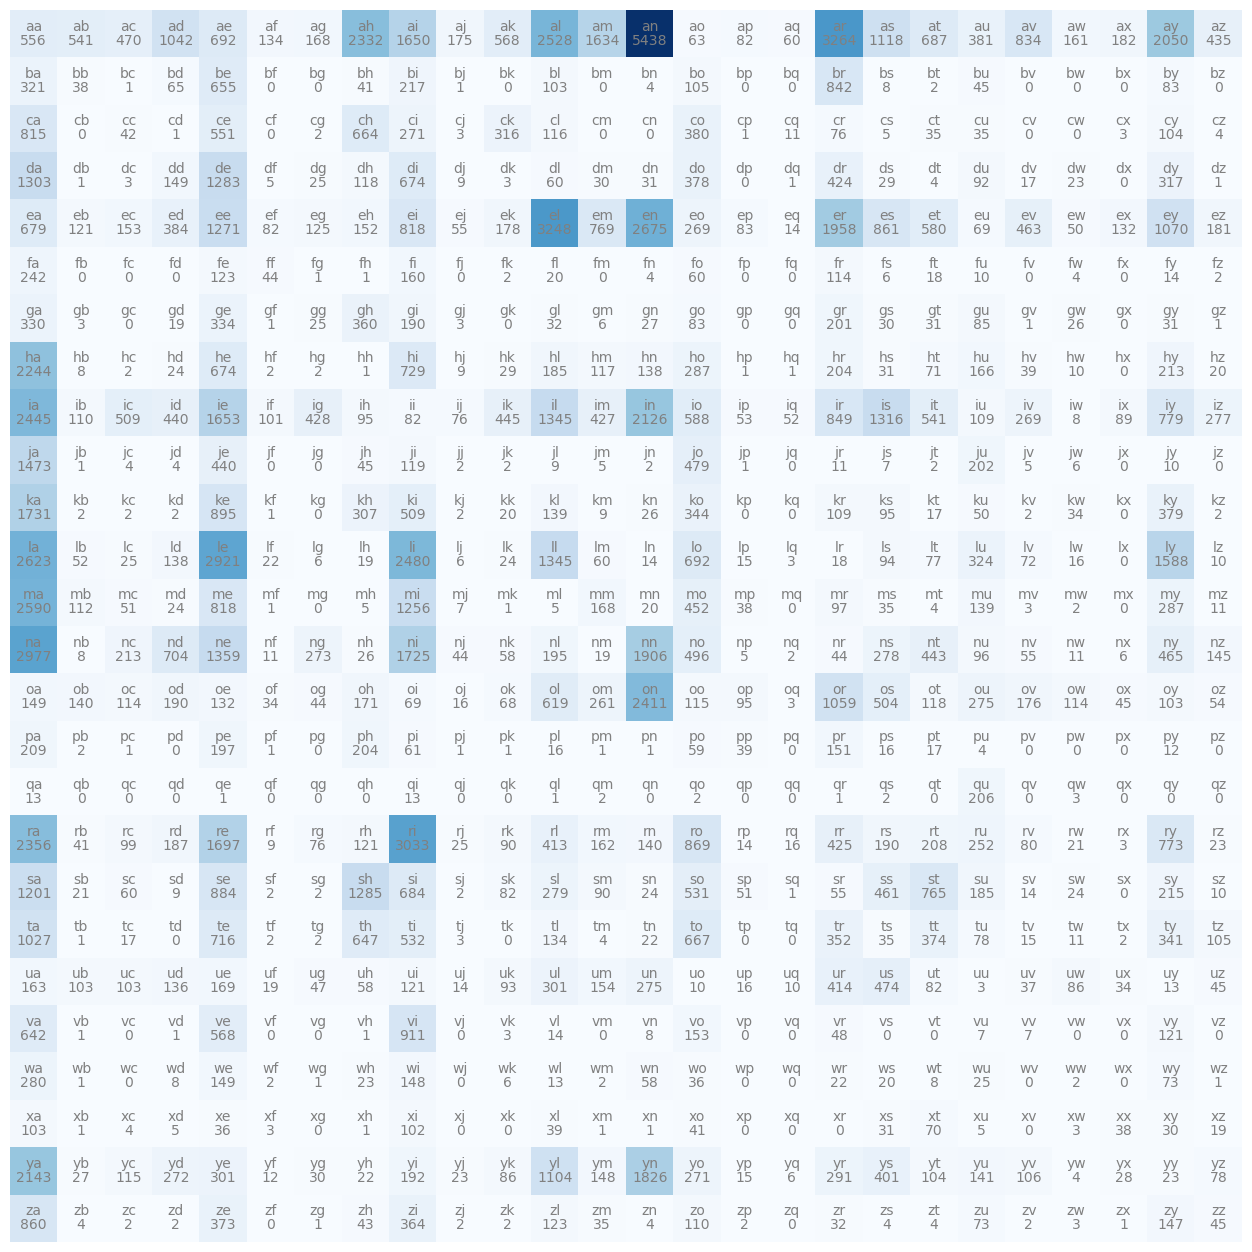

In [9]:
# Plot what alphabet comes after other alphabets
alphabet2idx = {char: idx for idx, char in enumerate(alphabet)}
idx2alphabet = {idx: char for char, idx in alphabet2idx.items()}
alphabet_matrix = torch.zeros(len(alphabet), len(alphabet), dtype=torch.int32)
for name in names:
    for char1, char2 in zip(name, name[1:]):
        alphabet_matrix[alphabet2idx[char1], alphabet2idx[char2]] += 1
plt.figure(figsize=(16, 16))
plt.imshow(alphabet_matrix, cmap='Blues')
for i in range(len(alphabet)):
    for j in range(len(alphabet)):
        chstr = idx2alphabet[i] + idx2alphabet[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, alphabet_matrix[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')
plt.show()
# This is the statistics we will use to build the bigram language model.

### Preprocessing

#### 1. Add special tokens

The matrix above has a problem. It does not indicate the beginning and end of a name.
- The model does not know what alphabet to start with.
- The model does not know when to stop generating a name.

To indicate the beginning and end of a name, we need to add special tokens.
- Beginning: `<S>`
- End: `<E>`

For example, the name "emma" will be "`<S>`emma`<E>`"

In [10]:
# Add special token
names = ["<S>" + name + "<E>" for name in names]
print(f"First 5 names: {names[:5]}")

First 5 names: ['<S>emma<E>', '<S>olivia<E>', '<S>ava<E>', '<S>isabella<E>', '<S>sophia<E>']


Let's use the **same** special token for the beginning and end of a name.

Why? Those two tokens will not get mixed up.

In [11]:
# Reload the data
names = load_text(config.root_dir + config.dataset_path).splitlines()

Loaded text data from c:\Users\delta\Documents\GitHub\LLM101n\notebooks\Lectures/../../data/names.txt (length: 228145 characters).


In [12]:
################################################################################
# TODO:                                                                        #
# Add the special token '.' to the beginning and end of each name.             #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
names = ["." + name + "." for name in names]
print(f"First 5 names: {names[:5]}")
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

First 5 names: ['.emma.', '.olivia.', '.ava.', '.isabella.', '.sophia.']


#### 2. Tokenizer

To feed the names to the model, we need to convert them to integers. Tokenization is the process of converting text to integers.

We will use a character-level tokenizer. ('.' -> 0, 'a' -> 1, 'b' -> 2 , ..., 'z' -> 26)

In [13]:
chars = [chr(i) for i in range(97, 123)]  # all alphabet characters
chars.insert(0, ".")  # Add special token
config.vocab_size = len(chars)
print(f"Characters: {chars}")
print(f"Vocab size: {config.vocab_size}")

Characters: ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab size: 27


In [14]:
# Create mapping
str2idx = {char: idx for idx, char in enumerate(chars)}
idx2str = {idx: char for char, idx in str2idx.items()}
print(f"str2idx: {str2idx}")
print(f"idx2str: {idx2str}")

str2idx: {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
idx2str: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### Part 1: Statistical approach

#### Statistics

What alphabet is likely to come after another alphabet?

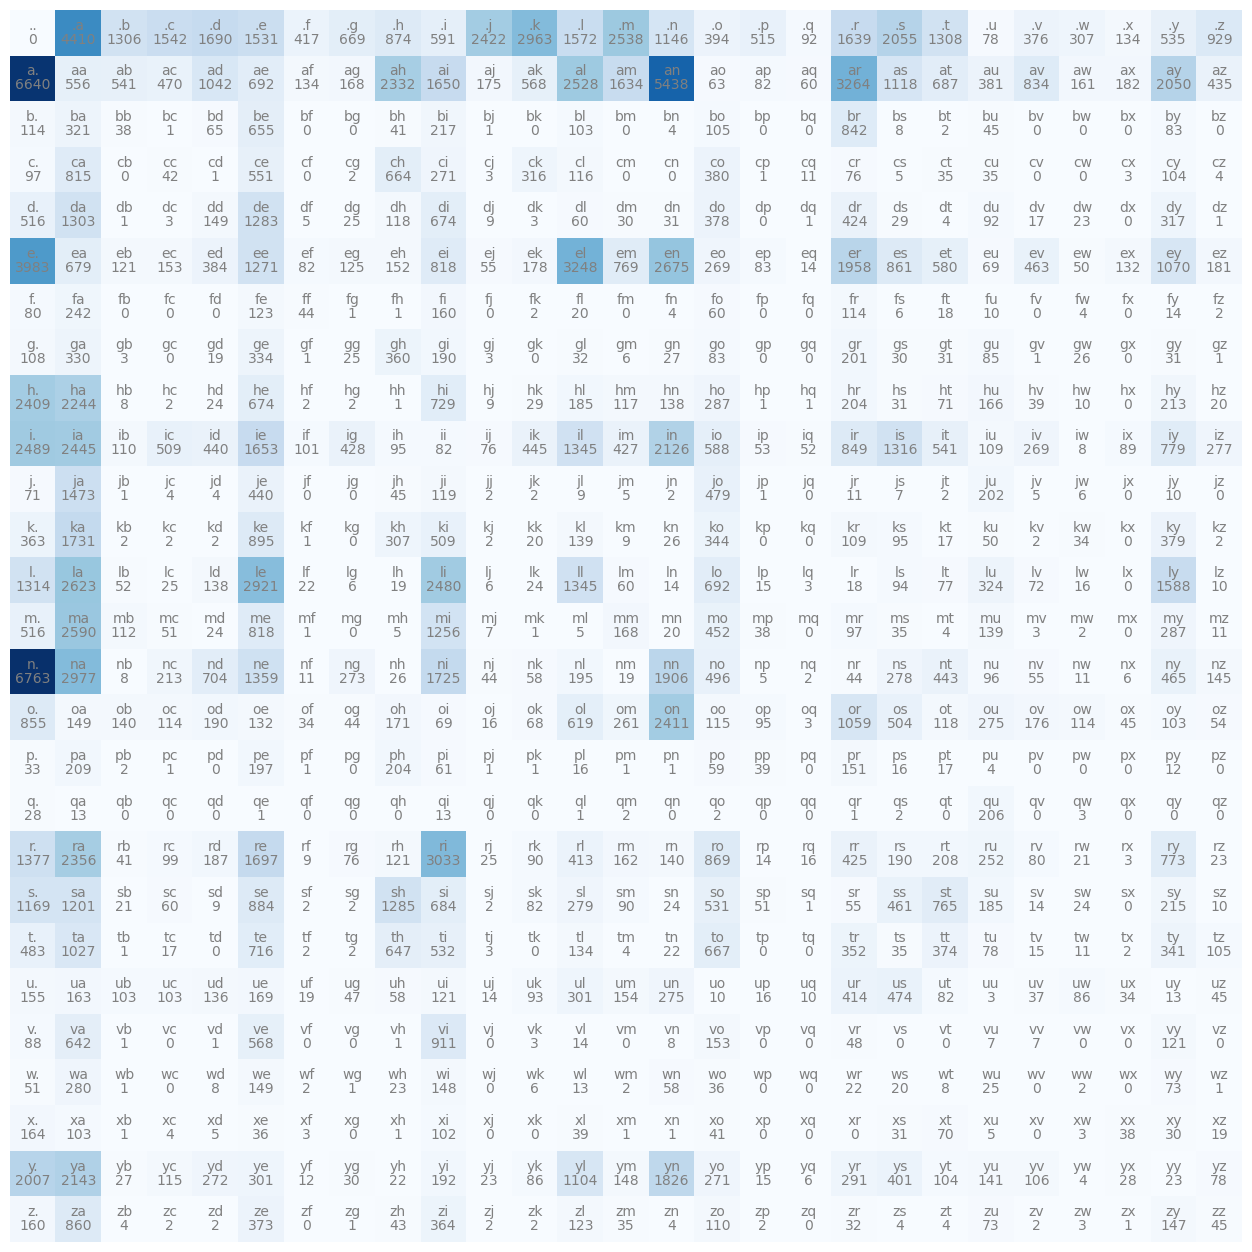

In [15]:
# Create a tensor to store what alphabet comes after other alphabets
char_matrix = torch.zeros(config.vocab_size, config.vocab_size, dtype=torch.int32)
for name in names:
    for char1, char2 in zip(name, name[1:]):
        char_matrix[str2idx[char1], str2idx[char2]] += 1
plt.figure(figsize=(16, 16))
plt.imshow(char_matrix, cmap='Blues')
for i in range(config.vocab_size):
    for j in range(config.vocab_size):
        stat = idx2str[i] + idx2str[j]
        plt.text(j, i, stat, ha='center', va='bottom', color='gray')
        plt.text(j, i, char_matrix[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')
plt.show()

In [16]:
################################################################################
# TODO:                                                                        #
# Get the probabilities by dividing the counts by the total counts             #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
prob = char_matrix / char_matrix.sum(dim=-1)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

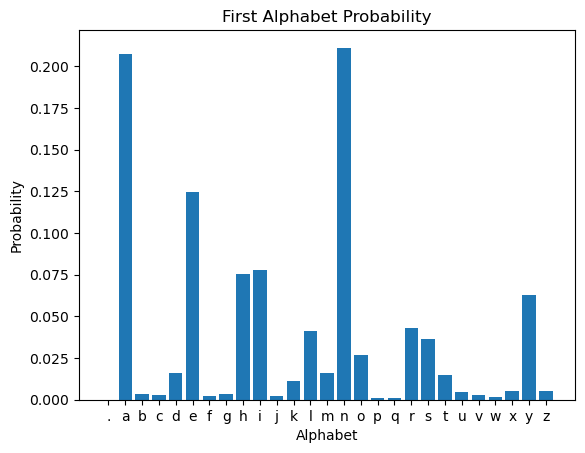

tensor([0.0000, 0.2073, 0.0036, 0.0030, 0.0161, 0.1243, 0.0025, 0.0034, 0.0752,
        0.0777, 0.0022, 0.0113, 0.0410, 0.0161, 0.2111, 0.0267, 0.0010, 0.0009,
        0.0430, 0.0365, 0.0151, 0.0048, 0.0027, 0.0016, 0.0051, 0.0627, 0.0050])


In [17]:
# Let's plot the probabilities for the first alphabet
plt.bar([idx2str[i] for i in range(config.vocab_size)], prob[:, 0])
plt.xlabel("Alphabet")
plt.ylabel("Probability")
plt.title("First Alphabet Probability")
plt.show()
print(prob[:, 0])

#### Inference

In [18]:
def generate_name(probs):
    new_name = []
    start_idx = str2idx["."]
    
    while True:
        # Sample
        print("------------------")
        print(f"Input: {idx2str[start_idx]}")
        print(f"Probabilities: {probs[start_idx]}")
        next_idx = torch.multinomial(probs[start_idx], num_samples=1, generator=generator).item()
        
        # Decode
        new_char = idx2str[next_idx]
        print(f"Output (probability): {new_char} ({probs[start_idx, next_idx]:.4f})")
        new_name.append(new_char)
        
        # Update
        start_idx = next_idx
        
        if next_idx == str2idx["."]:
            break
            
    return ''.join(new_name)

In [19]:
# Generate a random name
uniform_prob = torch.ones(config.vocab_size, config.vocab_size) / config.vocab_size
for _ in range(1):
    print(generate_name(uniform_prob))

------------------
Input: .
Probabilities: tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])
Output (probability): y (0.0370)
------------------
Input: y
Probabilities: tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])
Output (probability): d (0.0370)
------------------
Input: d
Probabilities: tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])
Output (probability): m (0.0370)
------------------
Input: m
Probabilities: tensor

In [20]:
# Generate a name based on the probabilities
for _ in range(1):
    print(generate_name(prob))

------------------
Input: .
Probabilities: tensor([0.0000, 0.1301, 0.4938, 0.4366, 0.3075, 0.0750, 0.4608, 0.3472, 0.1148,
        0.0334, 0.8352, 0.5879, 0.1126, 0.3821, 0.0625, 0.0497, 0.5019, 0.3382,
        0.1291, 0.2535, 0.2348, 0.0249, 0.1461, 0.3305, 0.1923, 0.0547, 0.3874])
Output (probability): j (0.8352)
------------------
Input: j
Probabilities: tensor([0.0022, 0.0435, 0.0004, 0.0011, 0.0007, 0.0215, 0.0000, 0.0000, 0.0059,
        0.0067, 0.0007, 0.0004, 0.0006, 0.0008, 0.0001, 0.0604, 0.0010, 0.0000,
        0.0009, 0.0009, 0.0004, 0.0644, 0.0019, 0.0065, 0.0000, 0.0010, 0.0000])
Output (probability): a (0.0435)
------------------
Input: a
Probabilities: tensor([0.2073, 0.0164, 0.2045, 0.1331, 0.1896, 0.0339, 0.1481, 0.0872, 0.3062,
        0.0932, 0.0603, 0.1127, 0.1811, 0.2460, 0.2967, 0.0079, 0.0799, 0.2206,
        0.2570, 0.1379, 0.1233, 0.1215, 0.3241, 0.1733, 0.2611, 0.2097, 0.1814])
Output (probability): w (0.1733)
------------------
Input: w
Probabilities: tensor

#### Evaluation

How should we evaluate the quality of the generated names?

In [21]:
################################################################################
# TODO:                                                                        #
# What is the probability of generating a random new token?                    #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
random_prob = 1/27
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
print(f"1 / vocab size: {random_prob}")

1 / vocab size: 0.037037037037037035


In [22]:
for name in names[:3]:
    for char1, char2 in zip(name, name[1:]):
        char1_id = str2idx[char1]
        char2_id = str2idx[char2]
        print(f"'{char1}' -> '{char2}': P={prob[char1_id, char2_id]:.4f}")

'.' -> 'e': P=0.0750
'e' -> 'm': P=0.1158
'm' -> 'm': P=0.0253
'm' -> 'a': P=0.0764
'a' -> '.': P=0.2073
'.' -> 'o': P=0.0497
'o' -> 'l': P=0.0443
'l' -> 'i': P=0.1401
'i' -> 'v': P=0.1045
'v' -> 'i': P=0.0515
'i' -> 'a': P=0.0722
'a' -> '.': P=0.2073
'.' -> 'a': P=0.1301
'a' -> 'v': P=0.3241
'v' -> 'a': P=0.0189
'a' -> '.': P=0.2073


Intuitively, we want to maximize the probability of generating the correct next token given the current token.
- Not learned: 1 / vocab_size = 0.037
- If learned, higher the better (should be higher than 0.037)

How can we summarize into a single number, that shows the quality of the model?

**Maximum Likelihood Estimation (MLE)**: Product of all probabilities
- Why use logarithm? multiplication -> addition



In [23]:
for name in names[:3]:
    for char1, char2 in zip(name, name[1:]):
        char1_id = str2idx[char1]
        char2_id = str2idx[char2]
        print(f"'{char1}' -> '{char2}': P={prob[char1_id, char2_id]:.4f}. LogP={torch.log(prob[char1_id, char2_id]):.4f}")

'.' -> 'e': P=0.0750. LogP=-2.5907
'e' -> 'm': P=0.1158. LogP=-2.1561
'm' -> 'm': P=0.0253. LogP=-3.6772
'm' -> 'a': P=0.0764. LogP=-2.5713
'a' -> '.': P=0.2073. LogP=-1.5737
'.' -> 'o': P=0.0497. LogP=-3.0026
'o' -> 'l': P=0.0443. LogP=-3.1157
'l' -> 'i': P=0.1401. LogP=-1.9654
'i' -> 'v': P=0.1045. LogP=-2.2581
'v' -> 'i': P=0.0515. LogP=-2.9668
'i' -> 'a': P=0.0722. LogP=-2.6289
'a' -> '.': P=0.2073. LogP=-1.5737
'.' -> 'a': P=0.1301. LogP=-2.0391
'a' -> 'v': P=0.3241. LogP=-1.1266
'v' -> 'a': P=0.0189. LogP=-3.9661
'a' -> '.': P=0.2073. LogP=-1.5737


In [25]:
# Log likelihood of first 3 names
# log(a*b) = log(a) + log(b)
log_likelihood = 0
n = 0
for name in names[:3]:
    for char1, char2 in zip(name, name[1:]):
        char1_id = str2idx[char1]
        char2_id = str2idx[char2]
        n += 1
        ################################################################################
        # TODO:                                                                        #
        # Log likelihood of the correct next token given the current token             #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        log_likelihood += torch.log(prob[char1_id,char2_id])
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
print(f"Average Log likelihood: {-log_likelihood / n:.4f}")
# We designed the loss function. yay!

Average Log likelihood: 2.4241


**Summary of what we've done so far**

Bigram Language Model
- Parameters: Tensor of size (vocab_size, vocab_size) -> Statistical approach
- Evaluation: Average Log likelihood of the correct next token given the current token


### Part 2: Neural Network approach

This time, we will use gradient descent and backpropagation to learn the probabilities.

#### Dataloader

We need to create a dataset of (Input, Target) pairs.
- Input: Current token
- Target: Next token

In [26]:
# Example of Input, Target pairs
example_name = names[0] # emma.
print(f"Name: {example_name}")

example_input0 = str2idx["."]  # 0
example_target0 = str2idx["e"]  # 5
print(f"Input: {example_input0}, Target: {example_target0}")

example_input1 = str2idx["e"]  # 5
example_target1 = str2idx["m"]  # 13
print(f"Input: {example_input1}, Target: {example_target1}")

Name: .emma.
Input: 0, Target: 5
Input: 5, Target: 13


In [29]:
# Set of Input, Target pairs
inputs, targets = [], []
for name in names:
    for char1, char2 in zip(name, name[1:]):
        ################################################################################
        # TODO:                                                                        #
        # Append the input string and target string to the inputs and targets list.    #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        input = str2idx[char1]
        target = str2idx[char2]
        inputs.append(input)
        targets.append(target)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Convert to tensor
inputs = torch.tensor(inputs, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")
print(f"First (Input, Target): ({inputs[0]}, {targets[0]})")
print(f"Second (Input, Target): ({inputs[1]}, {targets[1]})")

Input shape: torch.Size([228146])
Target shape: torch.Size([228146])
First (Input, Target): (0, 5)
Second (Input, Target): (5, 13)


#### One-hot Encoding

The model cannot take integers as input. (e.g., Input: 5, Target: 13)

The model expects a vector. One way to convert integers to vectors is to use one-hot encoding.
- Input: 5 -> [0, 0, 0, 0, 0, 1, 0, ..., 0]
- Target: 1 -> [0, 1, 0, 0, ..., 0]

PyTorch provides One-Hot Encoding functionality. [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html)

Read the documentation and implement the one-hot encoding.

In [31]:
# One-hot encoding
################################################################################
# TODO:                                                                        #
# Implement one-hot encoding for inputs and targets.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
inputs_encoded = F.one_hot(inputs, num_classes=27)
targets_encoded = F.one_hot(targets, num_classes=27)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Convert data type to float
inputs_encoded = inputs_encoded.float()
targets_encoded = targets_encoded.float()

print(f"Input shape: {inputs_encoded.shape}")
print(f"Target shape: {targets_encoded.shape}")
print(f"Input dtype: {inputs_encoded.dtype}")
print(f"Target dtype: {targets_encoded.dtype}")
print(f"First Input: {inputs_encoded[0]}")
print(f"First Target: {targets_encoded[0]}")

Input shape: torch.Size([228146, 27])
Target shape: torch.Size([228146, 27])
Input dtype: torch.float32
Target dtype: torch.float32
First Input: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
First Target: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


#### Model

Let's define the weights for a simple linear model.

y = Wx + b
- x: (data_size, vocab_size)
- W: (vocab_size, vocab_size)
- b: (vocab_size)
- y: (data_size, vocab_size)

What is torch.randn? [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.randn.html)

Why add requires_grad=True?
- If the tensor has requires_grad=False, PyTorch will not track operations on it, and it will not be able to calculate gradients. (saving memory)

In [32]:
# Initialize weights
W = torch.randn(config.vocab_size, config.vocab_size, generator=generator, requires_grad=True)
b = torch.randn(config.vocab_size, generator=generator, requires_grad=True)

print(f"W shape: {W.shape}")
print(f"b shape: {b.shape}")

W shape: torch.Size([27, 27])
b shape: torch.Size([27])


#### Training

In [33]:
# Example of forward pass
# data_size = 1
logits = torch.matmul(inputs_encoded[0], W) + b  # or use @
print(f"Input: {inputs_encoded[0]}")
print(f"Logits shape: {logits.shape}")
print(f"Logits: {logits}")

Input: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
Logits shape: torch.Size([27])
Logits: tensor([-8.4616e-01,  2.3262e-01, -4.4365e-01,  2.0858e-01,  6.4341e-01,
         5.3649e-01,  9.6742e-01, -1.1462e+00,  2.4424e+00, -3.5694e+00,
        -1.0091e+00,  2.6973e+00, -4.1754e-01,  4.5837e+00, -1.7289e+00,
         3.8317e-03,  1.0638e+00,  8.9011e-01, -8.0211e-01, -3.2701e+00,
        -5.5970e-01, -1.4568e+00, -2.5870e-01,  1.2106e+00, -1.0485e+00,
        -1.3717e+00,  1.4595e+00], grad_fn=<AddBackward0>)


In [ ]:
# TODO: Training loop


Q: What do we do to get the probability of an output?

A: **Softmax**
- Softmax converts logits to probabilities.
- Softmax: exp(x) / sum(exp(x))

In [34]:
# Probability matrix
prob = logits.exp() / logits.exp().sum(dim=-1, keepdim=True)
print(f"Probability shape: {prob.shape}")
print(f"Probability: {prob}")
print(f"Sum of Probability: {prob.sum()}")

Probability shape: torch.Size([27])
Probability: tensor([2.8185e-03, 8.2894e-03, 4.2153e-03, 8.0925e-03, 1.2501e-02, 1.1233e-02,
        1.7284e-02, 2.0880e-03, 7.5549e-02, 1.8507e-04, 2.3946e-03, 9.7481e-02,
        4.3268e-03, 6.4292e-01, 1.1658e-03, 6.5942e-03, 1.9034e-02, 1.5998e-02,
        2.9454e-03, 2.4963e-04, 3.7534e-03, 1.5304e-03, 5.0716e-03, 2.2043e-02,
        2.3021e-03, 1.6663e-03, 2.8272e-02], grad_fn=<DivBackward0>)
Sum of Probability: 0.9999999403953552


#### Inference

In [35]:
# Example prediction
next_idx = torch.multinomial(prob, num_samples=1, generator=generator).item()
print(f"Input: {inputs_encoded[0]}")
print(f"Output (probability): {next_idx} ({prob[next_idx]:.4f})")

Input: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
Output (probability): 13 (0.6429)


In [ ]:
# TODO: Generate a name